# Reuters 를 활용한 다중분류

In [1]:
# 일부만 할당된 GPU 메모리를 실행하는 동안 필요한만큼 늘릴 수 있도록 설정함
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [2]:
# 동일한 결과를 재현하기 위해서 random seed 고정
import numpy as np
np.random.seed(777)

In [3]:
# 모델 학습 시 불필요한 출력을 끄도록 함 (waning)

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

## 1. 데이터 준비

In [4]:
from tensorflow.keras.datasets import reuters
import numpy as np

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

2113536/2110848 [==============================] - 1s 0us/step


In [ ]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# 0, 1, 2는 '패딩', '문서 시작', '사전에 없음'을 위한 인덱스이므로 3을 뺍니다
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [7]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

## 2. 데이터 전처리

In [8]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# 훈련 데이터 벡터 변환
x_train = vectorize_sequences(train_data)
# 테스트 데이터 벡터 변환
x_test = vectorize_sequences(test_data)

In [9]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

Using TensorFlow backend.


In [11]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

## 3. 네트워크 정의

In [12]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

## 4. 모델 컴파일

In [13]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 5. 모델 학습

In [14]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 178us/step - loss: 2.5282 - acc: 0.4980 - val_loss: 1.7209 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 1s 124us/step - loss: 1.4458 - acc: 0.6883 - val_loss: 1.3490 - val_acc: 0.7090
Epoch 3/20
7982/7982 [==============================] - 1s 125us/step - loss: 1.0968 - acc: 0.7646 - val_loss: 1.1727 - val_acc: 0.7440
Epoch 4/20
7982/7982 [==============================] - 1s 123us/step - loss: 0.8713 - acc: 0.8155 - val_loss: 1.0866 - val_acc: 0.7570
Epoch 5/20
7982/7982 [==============================] - 1s 122us/step - loss: 0.7050 - acc: 0.8485 - val_loss: 0.9858 - val_acc: 0.7810
Epoch 6/20
7982/7982 [==============================] - 1s 123us/step - loss: 0.5677 - acc: 0.8794 - val_loss: 0.9426 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 1s 121us/step - loss: 0.4592 - acc: 0.9052 - val_loss: 0.9094 - val_acc: 0.8040


## 6. 학습 과정 확인

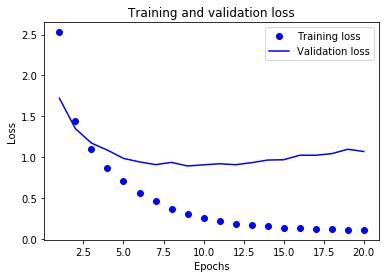

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 7. (과대적합 되기 전까지) 모델 학습

In [16]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 167us/step - loss: 2.5395 - acc: 0.5226 - val_loss: 1.6735 - val_acc: 0.6570
Epoch 2/9
7982/7982 [==============================] - 1s 125us/step - loss: 1.3720 - acc: 0.7116 - val_loss: 1.2761 - val_acc: 0.7210
Epoch 3/9
7982/7982 [==============================] - 1s 126us/step - loss: 1.0138 - acc: 0.7789 - val_loss: 1.1309 - val_acc: 0.7550
Epoch 4/9
7982/7982 [==============================] - 1s 127us/step - loss: 0.7976 - acc: 0.8247 - val_loss: 1.0534 - val_acc: 0.7590
Epoch 5/9
7982/7982 [==============================] - 1s 124us/step - loss: 0.6393 - acc: 0.8631 - val_loss: 0.9744 - val_acc: 0.7940
Epoch 6/9
7982/7982 [==============================] - 1s 124us/step - loss: 0.5110 - acc: 0.8926 - val_loss: 0.9093 - val_acc: 0.8140
Epoch 7/9
7982/7982 [==============================] - 1s 126us/step - loss: 0.4104 - acc: 0.9144 - val_loss: 0.8914 - val_acc: 0.8200
Epoch 8

## 8. 학습된 모델로 새로운 데이터 예측

In [17]:
predictions = model.predict(x_test)

In [18]:
predictions[0].shape

(46,)

In [19]:
np.sum(predictions[0])

1.0000002

In [20]:
np.argmax(predictions[0])

3

여기서부터는 추가적인 내용

## sparse_categorical_crossentropy

지금까지 해봤던 예시에서는, 개발자가 직접 예측값에 대해 one-hot-encoding 을 시켜주었어야 하는데,

loss 옵션에 sparse_categorical_crossentropy 를 주면, 케라스에서 알아서 원핫인코딩을 해줌,

In [21]:
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy', 
              metrics=['acc'])

## 충분히 큰 층을 두어야 하는 이유?

- 우리가 지금 input 에 넣은것은 10000개의 데이터인데, 이 데이터들이 전체를 대변하는 것은 당연히 아님.
- 보통은 깔대기 모양으로 (뒤의 층으로 갈수록) 유닛의 갯수를 맞춰주는 것이 일반적

In [22]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 200us/step - loss: 3.1696 - acc: 0.2433 - val_loss: 2.6142 - val_acc: 0.2740
Epoch 2/20
7982/7982 [==============================] - 1s 148us/step - loss: 2.0606 - acc: 0.5461 - val_loss: 1.7033 - val_acc: 0.5860
Epoch 3/20
7982/7982 [==============================] - 1s 147us/step - loss: 1.5012 - acc: 0.6233 - val_loss: 1.5122 - val_acc: 0.6390
Epoch 4/20
7982/7982 [==============================] - 1s 147us/step - loss: 1.2887 - acc: 0.6907 - val_loss: 1.4120 - val_acc: 0.6780
Epoch 5/20
7982/7982 [==============================] - 1s 155us/step - loss: 1.1457 - acc: 0.7159 - val_loss: 1.3673 - val_acc: 0.6830
Epoch 6/20
7982/7982 [==============================] - 1s 149us/step - loss: 1.0403 - acc: 0.7313 - val_loss: 1.3424 - val_acc: 0.6980
Epoch 7/20
7982/7982 [==============================] - 1s 152us/step - loss: 0.9587 - acc: 0.7424 - val_loss: 1.3385 - val_acc: 0.7010
